# Obtained_data:

In [2]:
import numpy as np 

In [3]:
import pandas as pd
user_data=pd.read_csv("Final_User_Dataset.csv")
item_data=pd.read_csv("Final_Anime_Dataset.csv")
user_input=pd.read_csv("User_input.csv")



In [4]:
user_data.columns

Index(['user_id', 'Username', 'Gender', 'Birth_Year', 'Mean Score',
       'Completed', 'avg_Action', 'avg_Adventure', 'avg_Avant Garde',
       'avg_Award Winning', 'avg_Boys Love', 'avg_Comedy', 'avg_Drama',
       'avg_Ecchi', 'avg_Erotica', 'avg_Fantasy', 'avg_Girls Love',
       'avg_Gourmet', 'avg_Hentai', 'avg_Horror', 'avg_Mystery', 'avg_Romance',
       'avg_Sci-Fi', 'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural',
       'avg_Suspense'],
      dtype='object')

In [33]:
item_data.columns
item_data.sample()

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Episodes,Aired,Premiered,...,Type_TV,Type_UNKNOWN,Rating_G - All Ages,Rating_PG - Children,Rating_PG-13 - Teens 13 or older,Rating_R - 17+ (violence & profanity),Rating_R+ - Mild Nudity,Rating_Rx - Hentai,Rating_UNKNOWN,Release_Year
10114,29770,Kikyuu,UNKNOWN,気球,5.64,UNKNOWN,"Music Video to 'Balloon' by People in the Box,...",1,"Sep 25, 2013",UNKNOWN,...,0,0,1,0,0,0,0,0,0,2013.0


In [6]:
item_data.drop(columns="Type", inplace=True)

In [7]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop=None, dtype=int)

# Fit and transform the 'Gender' column
gender_encoded = encoder.fit_transform(user_data[['Gender']])

# Get the column names for the encoded features
gender_columns = encoder.get_feature_names_out(['Gender'])

# Create a DataFrame for the encoded features
gender_encoded_df = pd.DataFrame(gender_encoded, columns=gender_columns)

# Concatenate the one-hot encoded columns with the original DataFrame
user_data = pd.concat([user_data, gender_encoded_df], axis=1)

# Drop the original 'Gender' column if no longer needed
user_data.drop(columns=['Gender'], inplace=True)

# Display the updated DataFrame
print(user_data.head())

   user_id  Username  Birth_Year  Mean Score  Completed  avg_Action  \
0        1     Xinil        1985        7.37      233.0        7.68   
1       20    vondur        1988        8.06       94.0        8.02   
2       66    Hiromi        1990        7.53      148.0        7.49   
3       82    Achtor        1989        7.17      153.0        7.36   
4      112  luffykun        1983        8.77      125.0        8.60   

   avg_Adventure  avg_Avant Garde  avg_Award Winning  avg_Boys Love  ...  \
0           7.90             8.00               8.18           7.06  ...   
1           8.24             9.00               8.43           7.06  ...   
2           7.31             7.00               7.90           7.06  ...   
3           7.71             8.80               8.25           7.06  ...   
4           8.36             7.91               9.80           7.06  ...   

   avg_Mystery  avg_Romance  avg_Sci-Fi  avg_Slice of Life  avg_Sports  \
0         7.86         7.27        7.37   

In [8]:
user_data.shape

(71285, 29)

In [9]:
user_data.columns

Index(['user_id', 'Username', 'Birth_Year', 'Mean Score', 'Completed',
       'avg_Action', 'avg_Adventure', 'avg_Avant Garde', 'avg_Award Winning',
       'avg_Boys Love', 'avg_Comedy', 'avg_Drama', 'avg_Ecchi', 'avg_Erotica',
       'avg_Fantasy', 'avg_Girls Love', 'avg_Gourmet', 'avg_Hentai',
       'avg_Horror', 'avg_Mystery', 'avg_Romance', 'avg_Sci-Fi',
       'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural', 'avg_Suspense',
       'Gender_Female', 'Gender_Male', 'Gender_Non-Binary'],
      dtype='object')

In [10]:
item_data.columns


Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Genres',
       'Synopsis', 'Episodes', 'Aired', 'Premiered', 'Status', 'Producers',
       'Licensors', 'Studios', 'Source', 'Duration', 'Rating', 'Rank',
       'Popularity', 'Favorites', 'Scored By', 'Members', 'Image URL',
       'Genre_Action', 'Genre_Adventure', 'Genre_Avant Garde',
       'Genre_Award Winning', 'Genre_Boys Love', 'Genre_Comedy', 'Genre_Drama',
       'Genre_Ecchi', 'Genre_Erotica', 'Genre_Fantasy', 'Genre_Girls Love',
       'Genre_Gourmet', 'Genre_Hentai', 'Genre_Horror', 'Genre_Mystery',
       'Genre_Romance', 'Genre_Sci-Fi', 'Genre_Slice of Life', 'Genre_Sports',
       'Genre_Supernatural', 'Genre_Suspense', 'Genre_UNKNOWN', 'Type_Movie',
       'Type_Music', 'Type_ONA', 'Type_OVA', 'Type_Special', 'Type_TV',
       'Type_UNKNOWN', 'Rating_G - All Ages', 'Rating_PG - Children',
       'Rating_PG-13 - Teens 13 or older',
       'Rating_R - 17+ (violence & profanity)', 'Rating_R+ - Mild Nudity

In [11]:

item_data.isna().sum()

anime_id                                    0
Name                                        0
English name                                0
Other name                                  0
Score                                    9213
Genres                                      0
Synopsis                                    0
Episodes                                    0
Aired                                       0
Premiered                                   0
Status                                      0
Producers                                   0
Licensors                                   0
Studios                                     0
Source                                      0
Duration                                    0
Rating                                      0
Rank                                        0
Popularity                                  0
Favorites                                   0
Scored By                                   0
Members                           

In [12]:
filtered_item_data_df = item_data.drop(columns=["Genres","Episodes","Rating_UNKNOWN",'Producers','Aired',"Premiered","Status","Studios","Licensors","Duration"])

In [13]:
filtered_item_data_df.columns

Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Synopsis',
       'Source', 'Rating', 'Rank', 'Popularity', 'Favorites', 'Scored By',
       'Members', 'Image URL', 'Genre_Action', 'Genre_Adventure',
       'Genre_Avant Garde', 'Genre_Award Winning', 'Genre_Boys Love',
       'Genre_Comedy', 'Genre_Drama', 'Genre_Ecchi', 'Genre_Erotica',
       'Genre_Fantasy', 'Genre_Girls Love', 'Genre_Gourmet', 'Genre_Hentai',
       'Genre_Horror', 'Genre_Mystery', 'Genre_Romance', 'Genre_Sci-Fi',
       'Genre_Slice of Life', 'Genre_Sports', 'Genre_Supernatural',
       'Genre_Suspense', 'Genre_UNKNOWN', 'Type_Movie', 'Type_Music',
       'Type_ONA', 'Type_OVA', 'Type_Special', 'Type_TV', 'Type_UNKNOWN',
       'Rating_G - All Ages', 'Rating_PG - Children',
       'Rating_PG-13 - Teens 13 or older',
       'Rating_R - 17+ (violence & profanity)', 'Rating_R+ - Mild Nudity',
       'Rating_Rx - Hentai', 'Release_Year'],
      dtype='object')

In [35]:
filtered_item_data_df.shape
filtered_item_data_df.sample(5)

,anime_id,Name,English name,Other name,Score,Synopsis,Source,Rating,Rank,Popularity,...,Type_Special,Type_TV,Type_UNKNOWN,Rating_G - All Ages,Rating_PG - Children,Rating_PG-13 - Teens 13 or older,Rating_R - 17+ (violence & profanity),Rating_R+ - Mild Nudity,Rating_Rx - Hentai,Release_Year
991,1091,Kidou Senshi Gundam II: Ai Senshi-hen,Mobile Suit Gundam II: Soldiers of Sorrow,機動戦士ガンダムⅡ 哀・戦士編,7.33000,"As the War continues, Amuro and the White Base...",Original,PG-13 - Teens 13 or older,2354,3632,...,0,0,0,0,0,1,0,0,0,1981.0
17264,43204,Gundam: G no Reconguista Movie III - Uchuu kar...,Gundam Reconguista in G III: Legacy from Space,劇場版 ガンダム Ｇのレコンギスタ Ⅲ 宇宙からの遺産,6.94000,"At Sankt Porto, the spaceships of the Amerian ...",Original,PG-13 - Teens 13 or older,4245,10452,...,0,0,0,0,0,1,0,0,0,2021.0
2636,2889,Bleach Movie 2: The DiamondDust Rebellion - Mo...,Bleach the Movie: The DiamondDust Rebellion,劇場版 BLEACH The DiamondDust Rebellion もう一つの氷輪丸,7.42000,Assigned to protect a royal procession transpo...,Manga,PG-13 - Teens 13 or older,2006,937,...,0,0,0,0,0,1,0,0,0,2007.0
8996,23819,Onimaru: Senjou ni Kakeru Itsutsu no Seishun,UNKNOWN,鬼丸 戦場に駆ける五つの青春,6.38089,During the Onin wars in Japan's medieval Murom...,Original,PG-13 - Teens 13 or older,18693,15163,...,0,0,0,0,0,1,0,0,0,1990.0
24792,55593,Holo no Graffiti Specials,Holo Graffiti Specials,ホロのぐらふぃてぃ,6.38089,Special episodes of Holo no Graffiti.,Other,PG-13 - Teens 13 or older,16492,13988,...,0,0,0,0,0,1,0,0,0,2019.0


In [15]:
filtered_item_data_df["Score"].isna().sum()

9213

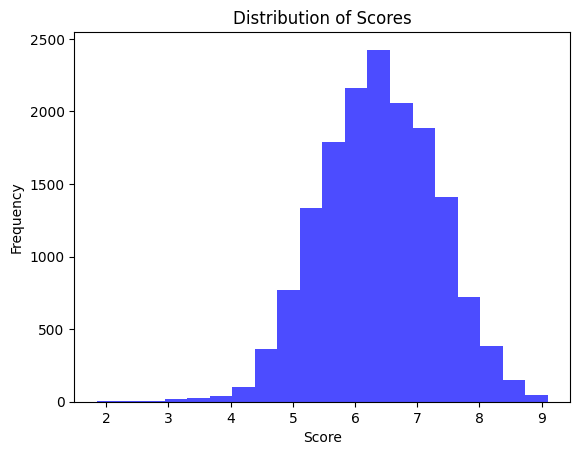

In [16]:
import matplotlib.pyplot as plt

plt.hist(filtered_item_data_df['Score'].dropna(), bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


In [17]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Replace 'UNKNOWN' with NaN for consistent handling of missing values
filtered_item_data_df['Score'] = filtered_item_data_df['Score'].replace('UNKNOWN', pd.NA)

# Initialize SimpleImputer with mean or median strategy
imputer = SimpleImputer(strategy='mean')  # Change to 'median' if distribution is skewed

# Apply imputation on the Score column
filtered_item_data_df['Score'] = imputer.fit_transform(filtered_item_data_df[['Score']])

# Verify that there are no missing values left in Score
print(filtered_item_data_df['Score'].isna().sum())  # Should print 0


0


In [18]:
# Keep rows where both 'Score' and 'Release_Year' are not null
filtered_item_data_df = filtered_item_data_df[filtered_item_data_df["Score"].notna() & filtered_item_data_df["Release_Year"].notna()]

In [19]:
print(filtered_item_data_df.isna().sum())

anime_id                                 0
Name                                     0
English name                             0
Other name                               0
Score                                    0
Synopsis                                 0
Source                                   0
Rating                                   0
Rank                                     0
Popularity                               0
Favorites                                0
Scored By                                0
Members                                  0
Image URL                                0
Genre_Action                             0
Genre_Adventure                          0
Genre_Avant Garde                        0
Genre_Award Winning                      0
Genre_Boys Love                          0
Genre_Comedy                             0
Genre_Drama                              0
Genre_Ecchi                              0
Genre_Erotica                            0
Genre_Fanta

In [20]:
filtered_item_data_df.shape

(20246, 50)

In [21]:
user_data.columns

Index(['user_id', 'Username', 'Birth_Year', 'Mean Score', 'Completed',
       'avg_Action', 'avg_Adventure', 'avg_Avant Garde', 'avg_Award Winning',
       'avg_Boys Love', 'avg_Comedy', 'avg_Drama', 'avg_Ecchi', 'avg_Erotica',
       'avg_Fantasy', 'avg_Girls Love', 'avg_Gourmet', 'avg_Hentai',
       'avg_Horror', 'avg_Mystery', 'avg_Romance', 'avg_Sci-Fi',
       'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural', 'avg_Suspense',
       'Gender_Female', 'Gender_Male', 'Gender_Non-Binary'],
      dtype='object')

In [22]:
filtered_item_data_df.columns

Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Synopsis',
       'Source', 'Rating', 'Rank', 'Popularity', 'Favorites', 'Scored By',
       'Members', 'Image URL', 'Genre_Action', 'Genre_Adventure',
       'Genre_Avant Garde', 'Genre_Award Winning', 'Genre_Boys Love',
       'Genre_Comedy', 'Genre_Drama', 'Genre_Ecchi', 'Genre_Erotica',
       'Genre_Fantasy', 'Genre_Girls Love', 'Genre_Gourmet', 'Genre_Hentai',
       'Genre_Horror', 'Genre_Mystery', 'Genre_Romance', 'Genre_Sci-Fi',
       'Genre_Slice of Life', 'Genre_Sports', 'Genre_Supernatural',
       'Genre_Suspense', 'Genre_UNKNOWN', 'Type_Movie', 'Type_Music',
       'Type_ONA', 'Type_OVA', 'Type_Special', 'Type_TV', 'Type_UNKNOWN',
       'Rating_G - All Ages', 'Rating_PG - Children',
       'Rating_PG-13 - Teens 13 or older',
       'Rating_R - 17+ (violence & profanity)', 'Rating_R+ - Mild Nudity',
       'Rating_Rx - Hentai', 'Release_Year'],
      dtype='object')

In [23]:
user_input.columns

Index(['Username', 'Gender', 'Mean Score', 'Completed', 'Birth_Year',
       'user_id', 'anime_id', 'Anime Title', 'rating', 'Genres',
       'Genre_Action', 'Genre_Adventure', 'Genre_Avant Garde',
       'Genre_Award Winning', 'Genre_Boys Love', 'Genre_Comedy', 'Genre_Drama',
       'Genre_Ecchi', 'Genre_Erotica', 'Genre_Fantasy', 'Genre_Girls Love',
       'Genre_Gourmet', 'Genre_Hentai', 'Genre_Horror', 'Genre_Mystery',
       'Genre_Romance', 'Genre_Sci-Fi', 'Genre_Slice of Life', 'Genre_Sports',
       'Genre_Supernatural', 'Genre_Suspense'],
      dtype='object')

In [36]:
# Check if any column in filtered_item_data_df contains the value 'UNKNOWN'
columns_with_unknown = filtered_item_data_df.columns[filtered_item_data_df.isin(['UNKNOWN']).any()]

# Print the columns that contain 'UNKNOWN'
print("Columns containing 'UNKNOWN':", list(columns_with_unknown))


Columns containing 'UNKNOWN': ['English name', 'Other name', 'Rating', 'Scored By']


In [37]:
def prepare_training_data(user_input_df, user_data_df, filtered_item_data_df):
    """
    Prepares training data for a neural network by merging dataframes and extracting
    user features (X_U), anime features (X_A), and ratings (Y).
    
    Parameters:
    -----------
    user_input_df : DataFrame
        Contains user ratings for anime with columns including user_id, anime_id, rating
    user_data_df : DataFrame
        Contains user demographic data and average genre ratings
    filtered_item_data_df : DataFrame
        Contains anime metadata including genres, types, and ratings
        
    Returns:
    --------
    dict
        A dictionary containing:
        - 'X_U': User features array
        - 'X_A': Anime features array
        - 'Y': Rating values array
        - 'X_U_columns': List of column names for user features
        - 'X_A_columns': List of column names for anime features
        - 'Y_column': Name of the rating column
        - 'X_U_indices': List of indices for user features
        - 'X_A_indices': List of indices for anime features
        - 'Y_index': Index of the rating column
        - 'merged_df': The merged and cleaned dataframe
    """
    import numpy as np
    
    # Step 1: Merge dataframes
    merged_df = user_input_df.merge(user_data_df, on='user_id')
    merged_df = merged_df.merge(filtered_item_data_df, on='anime_id')
    
    # Step 2: Identify columns to drop (non-numerical or identifiers)
    columns_to_drop = ['Username', 'user_id', 'anime_id', 'Anime Title', 
                      'Name', 'English name', 'Other name', 'Synopsis', 
                      'Source', 'Image URL']
    
    # Only drop columns that actually exist in the merged dataframe
    columns_to_drop = [col for col in columns_to_drop if col in merged_df.columns]
    
    # Drop identified columns
    cleaned_df = merged_df.drop(columns_to_drop, axis=1)
    
    # Step 3: Define columns for each component
    X_U_columns = ['Birth_Year', 'Mean Score', 'Completed',
                  'avg_Action', 'avg_Adventure', 'avg_Avant Garde', 'avg_Award Winning',
                  'avg_Boys Love', 'avg_Comedy', 'avg_Drama', 'avg_Ecchi', 'avg_Erotica',
                  'avg_Fantasy', 'avg_Girls Love', 'avg_Gourmet', 'avg_Hentai',
                  'avg_Horror', 'avg_Mystery', 'avg_Romance', 'avg_Sci-Fi',
                  'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural', 'avg_Suspense',
                  'Gender_Female', 'Gender_Male', 'Gender_Non-Binary']
    ## removed Scores and Rank from X_U_columns as they are not user features
    X_A_columns = ['Score', 'Popularity', 'Favorites',
                  'Members', 'Release_Year',
                  'Genre_Action', 'Genre_Adventure', 'Genre_Avant Garde', 'Genre_Award Winning',
                  'Genre_Boys Love', 'Genre_Comedy', 'Genre_Drama', 'Genre_Ecchi', 'Genre_Erotica',
                  'Genre_Fantasy', 'Genre_Girls Love', 'Genre_Gourmet', 'Genre_Hentai',
                  'Genre_Horror', 'Genre_Mystery', 'Genre_Romance', 'Genre_Sci-Fi',
                  'Genre_Slice of Life', 'Genre_Sports', 'Genre_Supernatural',
                  'Genre_Suspense', 'Genre_UNKNOWN',
                  'Type_Movie', 'Type_Music', 'Type_ONA', 'Type_OVA', 'Type_Special', 'Type_TV', 'Type_UNKNOWN',
                  'Rating_G - All Ages', 'Rating_PG - Children', 'Rating_PG-13 - Teens 13 or older',
                  'Rating_R - 17+ (violence & profanity)', 'Rating_R+ - Mild Nudity', 'Rating_Rx - Hentai']
    
    Y_column = 'rating'
    
    # Filter to include only columns that exist in the cleaned dataframe
    X_U_columns = [col for col in X_U_columns if col in cleaned_df.columns]
    X_A_columns = [col for col in X_A_columns if col in cleaned_df.columns]
    
    # Verify rating column exists
    if Y_column not in cleaned_df.columns:
        raise ValueError(f"Rating column '{Y_column}' not found in merged dataframe")
    
    # Step 4: Get indices for each component
    X_U_indices = [cleaned_df.columns.get_loc(col) for col in X_U_columns]
    X_A_indices = [cleaned_df.columns.get_loc(col) for col in X_A_columns]
    Y_index = cleaned_df.columns.get_loc(Y_column)
    
    # Step 5: Extract features using indices
    X_U = cleaned_df.iloc[:, X_U_indices].values
    X_A = cleaned_df.iloc[:, X_A_indices].values
    Y = cleaned_df.iloc[:, Y_index].values
    
    # Return all relevant data and metadata
    return {
        'X_U': X_U,
        'X_A': X_A,
        'Y': Y,
        'X_U_columns': X_U_columns,
        'X_A_columns': X_A_columns,
        'Y_column': Y_column,
        'X_U_indices': X_U_indices,
        'X_A_indices': X_A_indices,
        'Y_index': Y_index,
        'merged_df': cleaned_df
    }

In [38]:
result = prepare_training_data(user_input, user_data, filtered_item_data_df)

# Access the prepared data
X_U = result['X_U']  # User features
X_A = result['X_A']  # Anime features
Y = result['Y']      # Ratings

# You can also access indices if needed
X_U_indices = result['X_U_indices']
X_A_indices = result['X_A_indices']

In [39]:
X_U.shape

(8446992, 24)

In [40]:
X_A.shape

(8446992, 19)

In [41]:
Y.shape

(8446992,)

In [42]:
Y[:10]

array([9, 7, 5, 8, 8, 8, 7, 5, 6, 7], dtype=int64)

# Neural Network for implementing Content Based Filtering:

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import numpy as np

# --- Scaling the data ---
# Create scalers
user_scaler = StandardScaler()
anime_scaler = StandardScaler()

# Ensure all columns in X_A are numeric
# Convert categorical columns (e.g., 'Rating') to numeric using one-hot encoding
X_A_df = pd.DataFrame(X_A, columns=result['X_A_columns'])  # Convert X_A to DataFrame for easier processing

print(X_A_df.columns)  # Check the columns after encoding
# Scale the features
X_U_scaled = user_scaler.fit_transform(X_U)
X_A_scaled = anime_scaler.fit_transform(X_A_df)

# --- Splitting the scaled data ---
# First split: 80% train+val, 20% test
X_U_temp, X_U_test, X_A_temp, X_A_test, Y_temp, Y_test = train_test_split(
    X_U_scaled, X_A_scaled, Y, test_size=0.2, random_state=42
)

# Second split: 75% train, 25% validation (results in 60% train, 20% val, 20% test overall)
X_U_train, X_U_val, X_A_train, X_A_val, Y_train, Y_val = train_test_split(
    X_U_temp, X_A_temp, Y_temp, test_size=0.25, random_state=42
)

print(f"Training set: {X_U_train.shape[0]} samples")
print(f"Validation set: {X_U_val.shape[0]} samples")
print(f"Test set: {X_U_test.shape[0]} samples")




Index(['Score', 'Popularity', 'Favorites', 'Members', 'Release_Year',
       'Genre_UNKNOWN', 'Type_Movie', 'Type_Music', 'Type_ONA', 'Type_OVA',
       'Type_Special', 'Type_TV', 'Type_UNKNOWN', 'Rating_G - All Ages',
       'Rating_PG - Children', 'Rating_PG-13 - Teens 13 or older',
       'Rating_R - 17+ (violence & profanity)', 'Rating_R+ - Mild Nudity',
       'Rating_Rx - Hentai'],
      dtype='object')
Training set: 5068194 samples
Validation set: 1689399 samples
Test set: 1689399 samples


In [46]:
# --- TensorFlow model ---
# Set random seed for reproducibility
tf.random.set_seed(42)

# Define inputs for user and item features
user_input = tf.keras.Input(shape=(X_U_train.shape[1],), name="user_input")
item_input = tf.keras.Input(shape=(X_A_train.shape[1],), name="item_input")

# Define user network with dropout for regularization
user_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='linear')
], name="user_nn")

# Define item network with dropout for regularization
item_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='linear')
], name="item_nn")

# Pass inputs through respective networks
vu = user_nn(user_input)
va = item_nn(item_input)

# Compute dot product
output = tf.keras.layers.Dot(axes=1)([vu, va])

# Create model
model = tf.keras.Model([user_input, item_input], output)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# Model summary
model.summary()

# Train the model
history = model.fit(
    [X_U_train, X_A_train],
    Y_train,
    validation_data=([X_U_val, X_A_val], Y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_nn             │ (None, 32)        │     51,424 │ user_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_nn             │ (None, 32)        │     50,144 │ item_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ user_nn[0][0],    │
│                     │                   │            │ item_nn[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 101,568 (396.75 KB)

 Trainable params: 99,776 (389.75 KB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/10
158382/158382 ━━━━━━━━━━━━━━━━━━━━ 236s 1ms/step - loss: 2.8902 - mean_absolute_error: 1.1333 - val_loss: 1.5960 - val_mean_absolute_error: 0.9641 - learning_rate: 0.0010
Epoch 2/10
158382/158382 ━━━━━━━━━━━━━━━━━━━━ 230s 1ms/step - loss: 1.6580 - mean_absolute_error: 0.9799 - val_loss: 1.5770 - val_mean_absolute_error: 0.9552 - learning_rate: 0.0010
Epoch 3/10
158382/158382 ━━━━━━━━━━━━━━━━━━━━ 236s 1ms/step - loss: 1.6446 - mean_absolute_error: 0.9755 - val_loss: 1.5637 - val_mean_absolute_error: 0.9508 - learning_rate: 0.0010
Epoch 4/10
158382/158382 ━━━━━━━━━━━━━━━━━━━━ 343s 2ms/step - loss: 1.6341 - mean_absolute_error: 0.9723 - val_loss: 1.5562 - val_mean_absolute_error: 0.9468 - learning_rate: 0.0010
Epoch 5/10
158382/158382 ━━━━━━━━━━━━━━━━━━━━ 236s 1ms/step - loss: 1.6287 - mean_absolute_error: 0.9703 - val_loss: 1.5542 - val_mean_absolute_error: 0.9455 - learning_rate: 0.0010
Epoch 6/10
158382/158382 ━━━━━━━━━━━━━━━━━━━━ 404s 3ms/step - loss: 1.6244 - mean_absolute

In [47]:
# Evaluate on test set
test_results = model.evaluate([X_U_test, X_A_test], Y_test, verbose=1)
print(f"Test loss (MSE): {test_results[0]}")
print(f"Test MAE: {test_results[1]}")

52794/52794 ━━━━━━━━━━━━━━━━━━━━ 33s 631us/step - loss: 1.5475 - mean_absolute_error: 0.9433
Test loss (MSE): 1.5483520030975342
Test MAE: 0.9434724450111389


In [ ]:
# Save in TensorFlow SavedModel format
model.export('../saved_model/recommender_model_3')

# Save in HDF5 format
model.save('../saved_model/recommender_model_.h5', save_format='h5')


INFO:tensorflow:Assets written to: ../saved_model/recommender_model_2\assets


INFO:tensorflow:Assets written to: ../saved_model/recommender_model_2\assets


Saved artifact at '../saved_model/recommender_model_2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 24), dtype=tf.float32, name='user_input'), TensorSpec(shape=(None, 27), dtype=tf.float32, name='item_input')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2160430990736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2160430989968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2157435420112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2157435410128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2160430990544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2160430989584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2157435419920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2157435418576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2157435419728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2157435418192: TensorS

In [ ]:
# # Save in TensorFlow SavedModel format
# model.export('../saved_model/recommender_model_2')

# # Save in HDF5 format
# model.save('../recommender_model_2.h5', save_format='h5')


In [48]:
import numpy as np
X_U_test[:5]


array([[ 0.46190047,  0.37815348, -2.97543836, -1.26093178,  0.98347247,
         0.92062682,  0.35079441,  0.75541464,  0.58907733,  0.26881689,
         1.695232  ,  2.49770427,  0.08280445,  0.84669928,  0.26096726,
         0.12349649,  0.27844556,  2.34959646,  0.32731918,  0.43689757,
        -0.1087892 , -0.64291213,  0.65116801, -0.07305291],
       [-0.58657654, -0.95546682, -1.5417155 ,  0.02774076,  0.16394621,
        -0.11541749, -0.13286218,  0.06170569,  0.07447296, -0.72515181,
         0.83074883, -1.89529599,  0.36868352, -0.5157552 ,  0.07251483,
         0.24939922, -0.03560767, -0.2873906 , -1.70194325, -0.03082716,
        -0.61584162, -0.64291213,  0.65116801, -0.07305291],
       [ 0.58104559,  0.58509457,  0.21061245, -0.42266906,  0.16394621,
         1.5192302 ,  0.43988905,  1.55317993,  0.07447296,  0.52016529,
         0.39850725,  0.54525971,  1.55551484,  0.36010839,  1.02655525,
         0.89035856,  0.91818361,  1.23552053,  0.78851519,  1.24042468,
  

In [49]:
X_A_test[:5]

array([[-0.75624038,  1.45445452, -0.38465984, -0.71543982, -1.06417598,
        -0.07595064, -0.40376585, -0.06057058, -0.13043921, -0.33445704,
        -0.26418815,  0.69611806,  0.        , -0.19241824, -0.17800418,
         0.84974652, -0.54550152, -0.35212178, -0.11489196],
       [-0.83987969, -0.5261705 , -0.3449165 , -0.23824238,  0.89103501,
        -0.07595064, -0.40376585, -0.06057058, -0.13043921, -0.33445704,
        -0.26418815,  0.69611806,  0.        , -0.19241824, -0.17800418,
        -1.17682153, -0.54550152,  2.8399266 , -0.11489196],
       [-0.435623  ,  0.14798342, -0.37638309, -0.59424067,  0.19274537,
        -0.07595064,  2.47668295, -0.06057058, -0.13043921, -0.33445704,
        -0.26418815, -1.43653794,  0.        , -0.19241824, -0.17800418,
         0.84974652, -0.54550152, -0.35212178, -0.11489196],
       [-0.77018026, -0.35776441, -0.36333415, -0.39533027,  1.03069293,
        -0.07595064, -0.40376585, -0.06057058, -0.13043921, -0.33445704,
        -0.264

In [50]:
#Make predictions on X-U_test and X-A_test
predictions = model.predict([X_U_test[:10], X_A_test[:10]])
predictions[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


array([[7.792893 ],
       [7.1323004],
       [8.109898 ],
       [7.5148487],
       [7.4913893],
       [8.0916815],
       [6.3617377],
       [7.2879543],
       [6.9665856],
       [6.732585 ]], dtype=float32)

In [49]:
Y_test[:10]

array([ 8, 10, 10,  7,  7,  8,  4, 10,  7,  9], dtype=int64)

In [ ]:
# Optional: Plot training history
# Uncomment if you're running in an environment that supports plotting
"""
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()
"""

Utilizing MLP from scikit learn 